In [1]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import GP_CommonCalculation as GP
import kernel
from kernel import RBFKernel, LinearKernel, RationalQuadraticKernel, PeriodicKernel
import torch.optim as optim
import importlib

print(torch.__version__)
# I use torch (1.11.0) for this work. lower version may not work.
from cigp_v10 import cigp
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

2.2.1
2.2.1


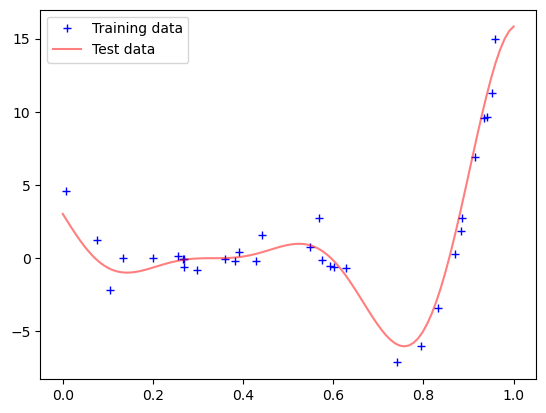

In [2]:
# generate example data
xtr, ytr,xte,yte = data.generate(32,100,seed=42)
data.plot(xtr, ytr,xte,yte)

In [3]:
class neural_kernel(nn.Module):
    def __init__(self, x_dim, num_kernels=3):
        """
        Initializes the neural_kernel class.

        Parameters:
        - x_dim (int): The number of dimensions (features) in the input data. This is used for ARD in the kernels.
        - num_kernels (int): The number of different kernels whose outputs will be combined. Default is 3.
        """
        super(neural_kernel, self).__init__()
        self.RBFKernel_1 = RBFKernel(x_dim)
        self.RQKern_1 = RationalQuadraticKernel(x_dim)
        self.PerKern_1 = PeriodicKernel(x_dim)
        self.linear_1 = nn.Linear(num_kernels, 1)
        nn.init.uniform_(self.linear_1.weight, a=0.5 * 1. / (2 * self.linear_1.in_features),
                         b=0.5 * 3. / (2 * self.linear_1.in_features))

    def forward(self, x1, x2):
        """
        Forward pass through the neural kernel network.

        Parameters:
        - x1 (Tensor): The first input tensor.
        - x2 (Tensor): The second input tensor.

        Returns:
        - var_act (Tensor): The output tensor after applying the kernels, linear layer, and activation function.
        """
        var1 = self.RBFKernel_1.forward(x1, x2)
        var2 = self.PerKern_1.forward(x1, x2)
        var3 = self.RQKern_1.forward(x1, x2)
        var = torch.stack((var1, var2, var3), dim=-1)  # Stack along a new dimension (third dimension)
        var_lin1 = self.linear_1(var).reshape(var1.shape)
        var_act = torch.exp(var_lin1)
        return var_lin1#var_act

In [4]:
x_dim= xtr.size(1)
kernel= neural_kernel(x_dim)

In [5]:
#initiate_log_beta
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value.

In [6]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta):
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))
    return -GP.Gaussian_log_likelihood(ytr, Sigma)


In [7]:
def forward(xtr, ytr, xte, kernel,log_beta):
    n_test = xte.size(0)
    #xte=data_normalizer.normalize(xte)
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))

    K_s = kernel(xtr, xte)
    K_ss= kernel(xte, xte)

    mean, var = GP.conditional_Gaussian(ytr, Sigma, K_s, K_ss)

    var_diag = var.sum(dim=0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)

    # Denormalize
    #mean, var_diag = data_normalizer.denormalize_result(mean, var_diag)
    return mean, var_diag

In [8]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        if i % 10 == 0:
            print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [9]:
train_adam(xtr, ytr, kernel, log_beta, niteration=300,lr=0.01)

iter 0 nll:100.13283
iter 10 nll:99.19533
iter 20 nll:98.32220
iter 30 nll:97.50642
iter 40 nll:96.73741
iter 50 nll:95.99857
iter 60 nll:95.26967
iter 70 nll:94.51790
iter 80 nll:93.60455
iter 90 nll:91.41542
iter 100 nll:90.10162
iter 110 nll:88.61752
iter 120 nll:87.20313
iter 130 nll:85.86676
iter 140 nll:84.59161
iter 150 nll:83.36053
iter 160 nll:82.16724
iter 170 nll:81.00974
iter 180 nll:79.88416
iter 190 nll:78.78777
iter 200 nll:77.71883
iter 210 nll:76.67651
iter 220 nll:75.66081
iter 230 nll:74.67256
iter 240 nll:73.71310
iter 250 nll:72.78430
iter 260 nll:71.88835
iter 270 nll:71.02760
iter 280 nll:70.20450
iter 290 nll:69.42145


In [10]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel,log_beta)

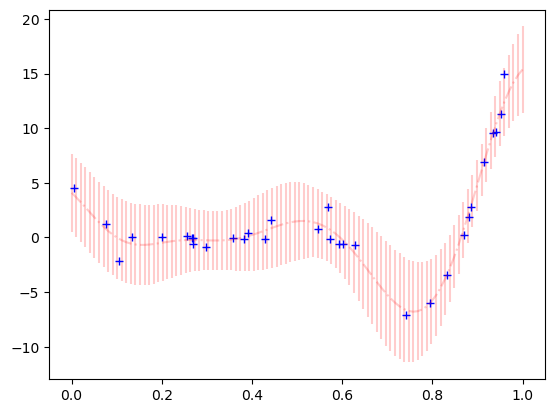

In [11]:
#xtr,ytr=data_normalizer.denormalize(xtr,ytr)
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()

In [13]:
#Comparing with standard GP
model2=cigp(xtr, ytr)
model2.train_adam(100,0.01)
with torch.no_grad():
    ypred2, yvar2 = model2.forward(xte)
mse_neuralKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
print('mse_neuralKernel:',mse_neuralKernel)
print('mse_standardGP:',mse_standardGP)

iter 0 nll:43.43343
iter 10 nll:42.49739
iter 20 nll:41.21923
iter 30 nll:39.46359
iter 40 nll:37.34563
iter 50 nll:35.20496
iter 60 nll:33.34231
iter 70 nll:31.81442
iter 80 nll:30.49278
iter 90 nll:29.26431
mse_neuralKernel: tensor(0.3753)
mse_standardGP: tensor(0.4386)
